# Analyze EEG data

This notebook will help you prepare the figures for your EEG lab report.

To run this notebook:

1. <mark>Export two separate **LabChart Text File (.txt)** of 30 seconds of data for <i>both</i> eyes open and closed. </mark>
2. Upload the file to Colab.
3. Change the filename below to match the name of your file.

In [1]:
import numpy as np

# Change the filenames to EXACTLY match your files
closed_filename = 'EEG_Trial1_EyesClosed.txt'
open_filename = 'EEG_Trial1_EyesOpen.txt'

sampling_freq = 400

# Define column names
columns = ['time', 'recording']

# Use numpy genfromtxt to import both files
closed_data = np.genfromtxt(closed_filename, dtype=float, usecols=(0,1), skip_header=6, delimiter='\t', names=columns, encoding = 'unicode_escape')
open_data = np.genfromtxt(open_filename, dtype=float, usecols=(0,1), skip_header=6, delimiter='\t', names=columns, encoding = 'unicode_escape')

# Define a function to remove nan values
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

# Save recording & timestamps as variables
closed_timestamps = closed_data['time']
closed_recording = closed_data['recording']
nans, x = nan_helper(closed_recording)
closed_recording[nans]= np.interp(x(nans), x(~nans), closed_recording[~nans])

open_timestamps = open_data['time']
open_recording = open_data['recording']
nans, x = nan_helper(open_recording)
open_recording[nans]= np.interp(x(nans), x(~nans), open_recording[~nans])

closed_recording

array([-125.95   , -124.95   , -139.2875 , ...,   69.21875,   63.8625 ,
         59.76875])

## Plot the data
Now, we can plot the data!

**Notes**:
* You may want to change the x and y labels below.
* You can also uncomment the line that says `plt.xlim` to change how much of the data is plotted.
* You can use this same cell to plot your eyes open data by changing `closed_timestamps` to `open_timestamps` and `closed_recording` to `open_recording`.

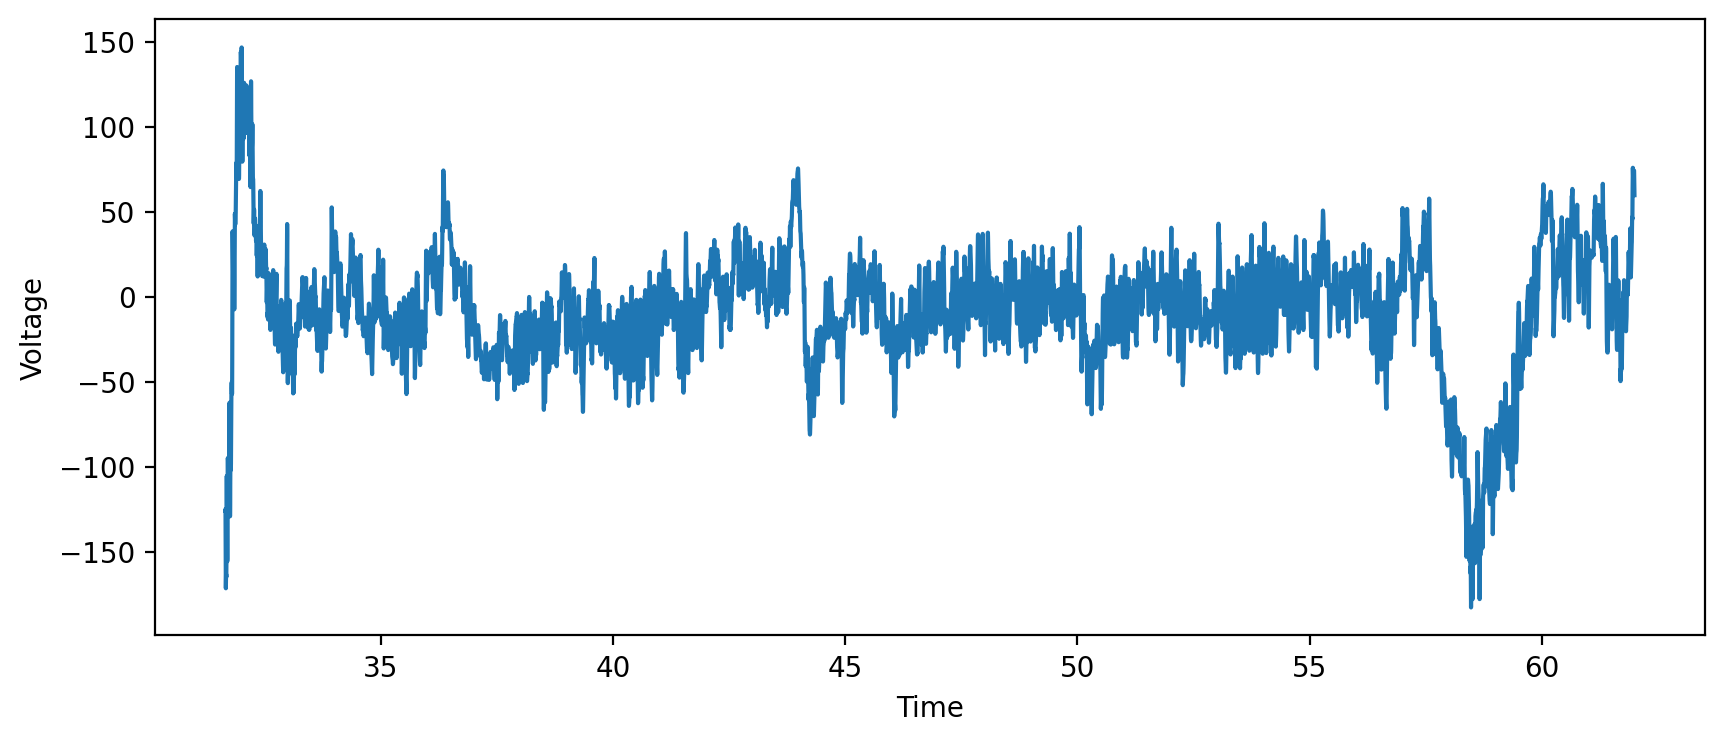

In [2]:
# Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Set up figure
fig,ax = plt.subplots(figsize=(10,4))

# Change the variables below if you'd like to plot eyes open instead
plt.plot(closed_timestamps,closed_recording)

# You may need to change the x label!
plt.xlabel('Time') 

# You may need to change the y label!
plt.ylabel('Voltage')

# You can uncomment the line below to restrict the x axis plotting -- for example, to zoom into alpha waves
#plt.xlim([45,50])

plt.show()

##  Calculate the power spectrum of our EEG data
Below, we'll implement a **fast Fourier transform** (fft) to see the frequencies in our data.

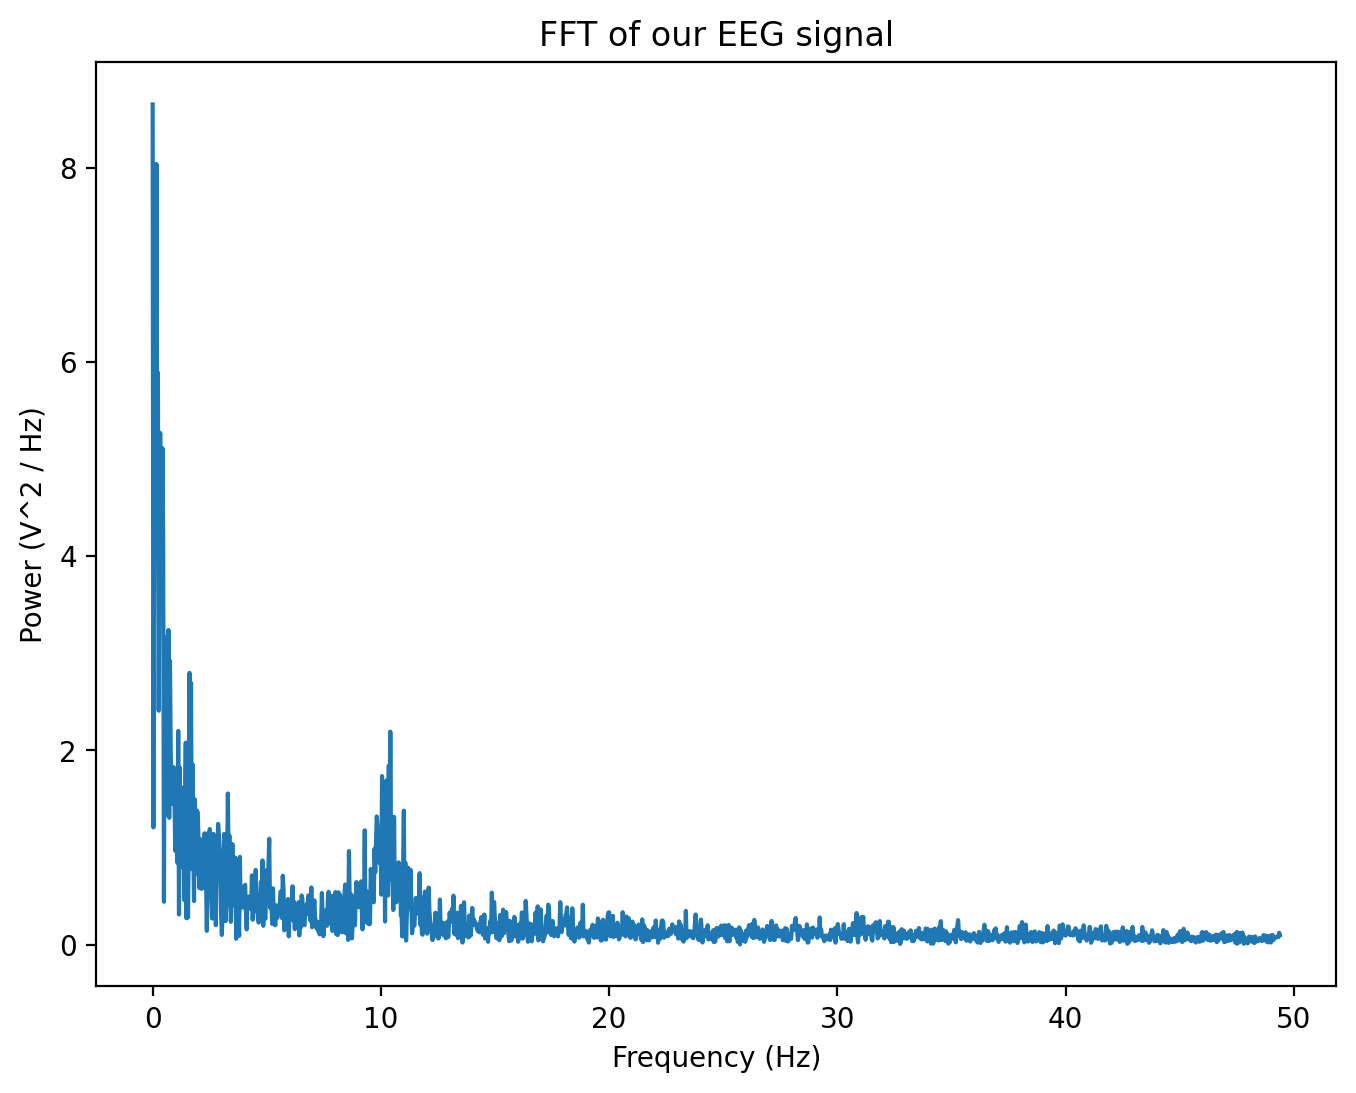

In [3]:
# Calculate the fourier transform of complex signal
ft = np.fft.fft(closed_recording)/len(closed_timestamps) # Compute the fft, normalized by time

# Find frequency values for the x axis
nyq = sampling_freq/2 # Determine the nyquist frequency

# Create freq bins for plotting by creating a vector from 0 to nyquist, with as many points as in fft
fx_bins = np.linspace(0,nyq,int(np.floor(len(closed_recording)/2))+1)

# plotting up to 200 Hz
plt.figure(figsize=(8, 6))
plt.plot(fx_bins[0:1500],abs(ft[0:1500]))
plt.ylabel('Power (V^2 / Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of our EEG signal')
plt.show()

Hmm, this is interesting but a bit noisy. Maybe we need a method that is _better_ than the simple fast fourier transform for this type of data. Thankfully, there's a way to smooth out our fft without losing too much information. 

The most widely-used method to do that is [**Welch's Method**](https://en.wikipedia.org/wiki/Welch%27s_method), which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. Basically, we calculate the fft of a signal across a few sliding windows, and then calculate the mean PSD from all the sliding windows. This is how LabChart generates the **power spectral density** plot as well!

The `freqs` vector contains the x-axis (frequency bins) and the `psd` vector contains the y-axis (power spectral density). The units of the power spectral density here are V^2 per Hz, reflecting that these values are for a particular frequency range.

**Notes**:
* <mark>Check that the values here are *almost identical* to your PSD in LabChart. If not, you may need to change the y-axis labels.</mark>
* If you'd like to plot both the eyes opened and closed data, you can uncomment the three lines indicated below.
* You can change the x limit by uncommenting & editing the `plt.xlim` line.

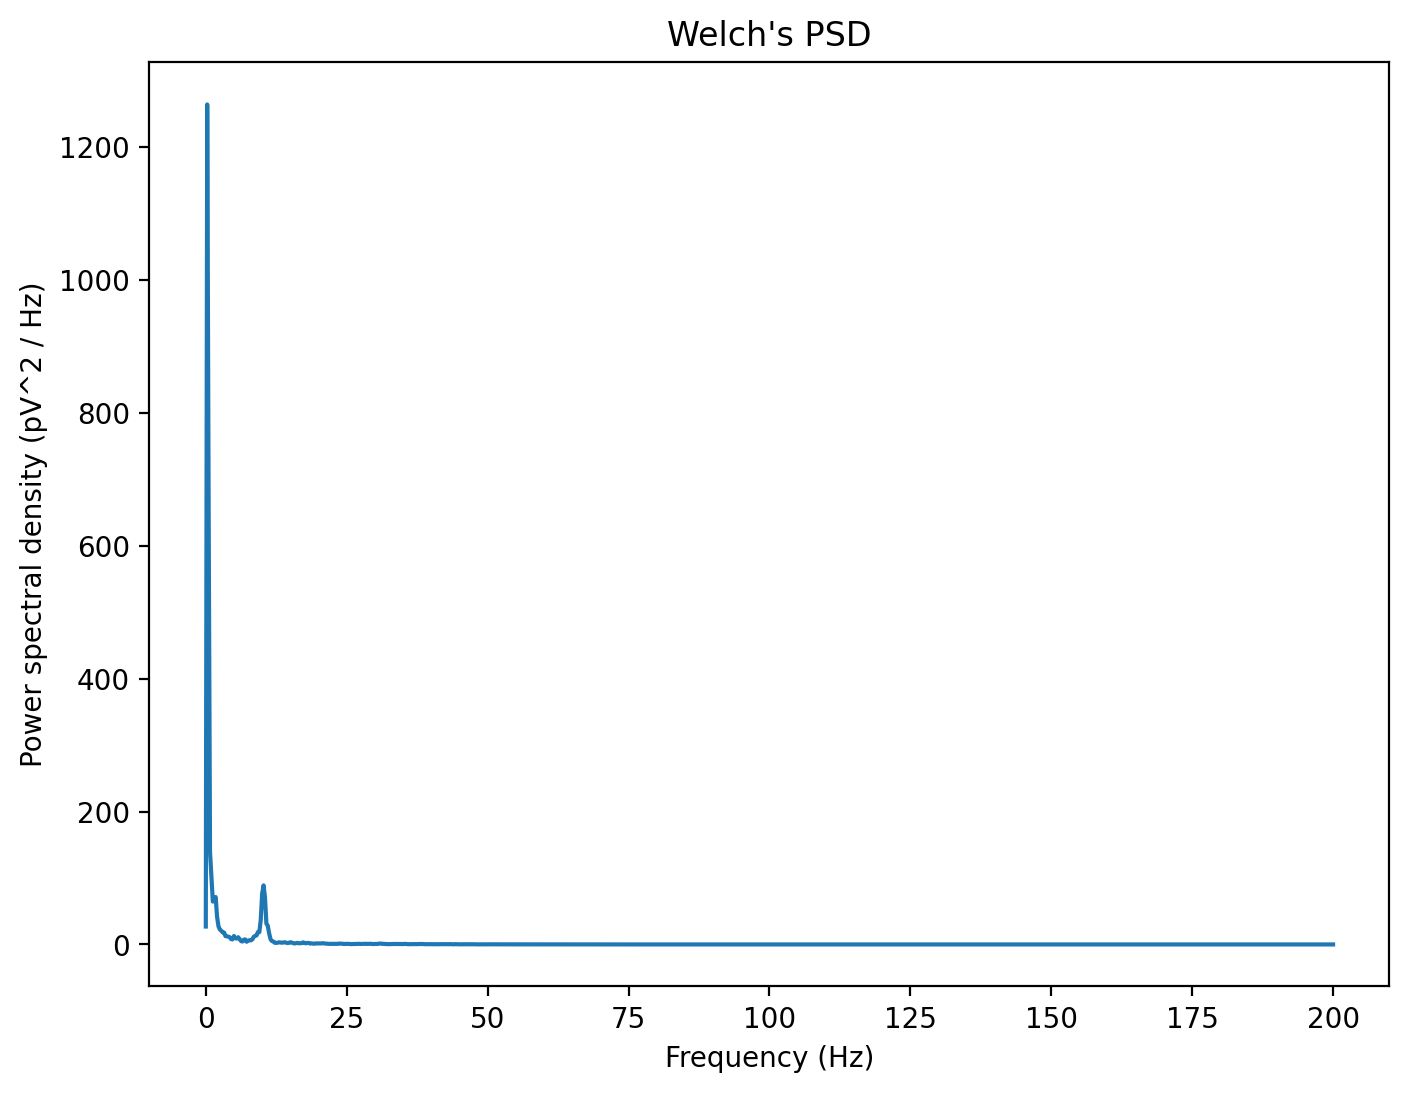

In [4]:
from scipy import signal

# Define sliding window length (4 seconds, which will give us 2 full cycles at 0.5 Hz)
win = 4 * sampling_freq
freqs, psd = signal.welch(closed_recording, sampling_freq, nperseg=win)

# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.plot(freqs, psd)

# Uncomment the lines below to plot two lines
#open_freqs, open_psd = signal.welch(open_recording, sampling_freq, nperseg=win)
#plt.plot(open_freqs, open_psd)
#plt.legend(['Closed','Open'])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (pV^2 / Hz)') # Check that these units make sense!
#plt.xlim([0,75]) # Change x limit

plt.title("Welch's PSD")
plt.show()

## Generate & plot spectrogram
As a final step, we can plot a **spectrogram** of our signal. This is a common way to visualize EEG signals. The spectrogram results from doing the FFT on the snippet of the signal that falls into a “window,” plotting the frequency content in the window, then moving the window in time and plotting the frequency content again (and again) until the window has moved across the entire signal.

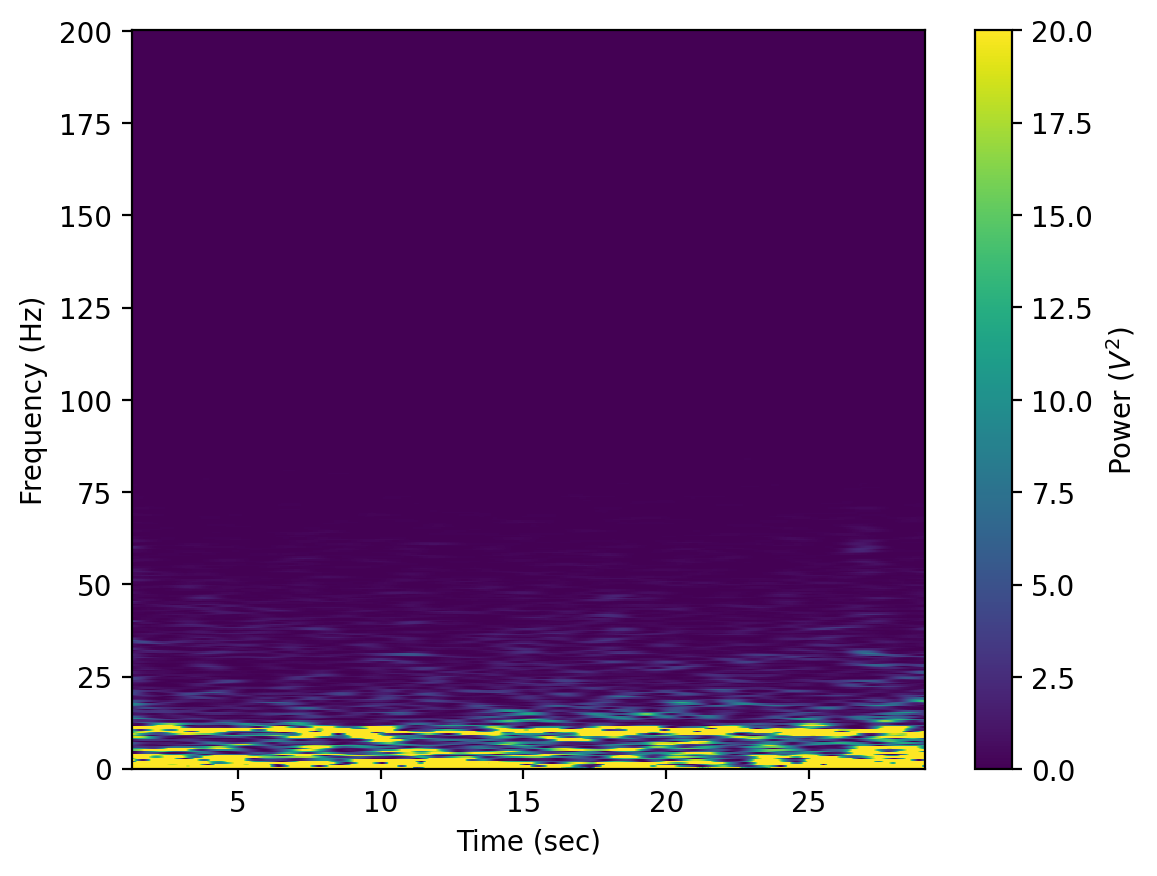

In [5]:
vmax = 20 # change the max value on your spectogram -- you may need to adjust this

wind = np.hanning(1024) # Create a "hanning" window with a given binning window size

# Create the spectrogram and plot
fig = plt.figure() 

# Change closed to open below to generate for open
f, tt, Sxx = signal.spectrogram(closed_recording,sampling_freq,wind,len(wind),len(wind)-1)

# You can change cmap & vmax if you want
plt.pcolormesh(tt,f,Sxx,cmap='viridis',vmax=vmax)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
# plt.ylim([0,75]) # set the ylimit
cbar = plt.colorbar()
cbar.ax.set_ylabel('Power ($V^2$)')
plt.show()